### Import Library and load dataset

In [1]:
ls

DepVsAnxiety.csv  sample_data/


In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras_nlp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud


In [9]:
Data = pd.read_csv('DepVsAnxiety.csv', index_col=0)


Data.head()

,status,statement
0,depression,school makes me suicidal (please help) im a 16...
1,depression,I give up. Failed I just want to wipe my hands...
2,depression,"depressed over the holidays No calls, messages..."
3,depression,It’s hard I don’t want to go back to school th...
4,depression,Year in Pixels I'm going to be doing one of th...


In [10]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32038 entries, 0 to 2824
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   status     32038 non-null  object
 1   statement  32038 non-null  object
dtypes: object(2)
memory usage: 750.9+ KB


<Axes: ylabel='status'>

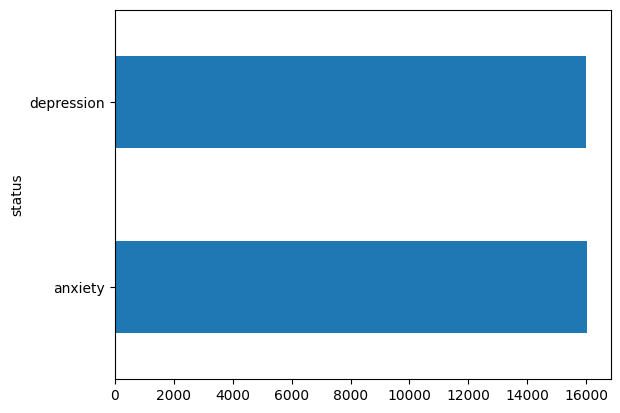

In [12]:
Data['status'].value_counts().plot(kind='barh')

In [13]:
Data['label'], names = pd.factorize(Data['status']) # Label encoder

for i, name in enumerate(names):
    print(f" {i}: {name}")

Data['label'].value_counts()

 0: depression
 1: anxiety


,count
label,
1,16038
0,16000


#### splitting the dataset

In [15]:
X = Data['statement']
y = Data['label']

# Perform stratified split: 60% for training, 20% for validation and 20 for test
trainX, X_val, trainY, y_val = train_test_split(X, y, test_size=0.2,  random_state=42)
X_train, X_test, y_train, y_test = train_test_split(trainX, trainY, test_size=0.2, random_state=42)


# Combine the split data back into DataFrames for easier handling later
train_dataset = pd.DataFrame({'statement': X_train, 'label': y_train})
val_dataset = pd.DataFrame({'statement': X_val, 'label': y_val})
test_dataset = pd.DataFrame({'statement': X_test, 'label': y_test})

In [16]:
train_dataset_ = tf.data.Dataset.from_tensor_slices((train_dataset['statement'].values, train_dataset['label'].values))
val_dataset_ = tf.data.Dataset.from_tensor_slices((val_dataset['statement'].values, val_dataset['label'].values))
test_dataset_ = tf.data.Dataset.from_tensor_slices((test_dataset['statement'].values, test_dataset['label'].values))

train_ds = train_dataset_.shuffle(buffer_size=1000)
val_ds = val_dataset_.shuffle(buffer_size=1000)
test_ds = test_dataset_.shuffle(buffer_size=1000)

##Vectorisation

In [17]:
max_length = 500
max_tokens = 15000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int", output_sequence_length=max_length,)

text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

In [18]:
import pickle

# Save the vectorizer to a file
with open('text_vectorization_DvsA.pkl', 'wb') as f:
    pickle.dump(text_vectorization, f)

In [19]:
train_int = train_ds.map( lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
val_int = val_ds.map( lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)
test_int = test_ds.map( lambda x, y: (text_vectorization(x), y), num_parallel_calls=4)



### first training

In [21]:
# Input: tokenized and padded sequences

NUM_HEADS = 2
BATCH_SIZE = 64
EPOCHS = 10
max_length = 500
max_tokens = 15000
EMBED_DIM = 100
INTERMEDIATE_DIM = 128

input_ids = keras.Input(shape=(None,), dtype="int64", name="input_ids")

# Token and position embedding (with mask_zero=True to generate a padding mask)
x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=max_tokens,
    sequence_length=max_length,
    embedding_dim=EMBED_DIM)(input_ids)


# First TransformerEncoder layer
x = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM,
    num_heads=NUM_HEADS
)(x)

# Second TransformerEncoder layer
x = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM,
    num_heads=NUM_HEADS
)(x)


# Pooling, Dropout, and Output Layer for classification
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

# Final Model
DepVsAnx_classifier = keras.Model(input_ids, outputs, name="DepVsAnx_classifier")

In [22]:
DepVsAnx_classifier.summary()

Model: "DepVsAnx_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding_1       │ (None, None, 100)           │       1,550,000 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_2                │ (None, None, 100)           │          66,628 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_3                │ (None, None, 100)           │          66,628 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 100)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,683,357 (6.42 MB)

 Trainable params: 1,683,357 (6.42 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:

train_int = train_int.batch(BATCH_SIZE)
val_int = val_int.batch(BATCH_SIZE)

DepVsAnx_classifier.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])


callbacks = [
 keras.callbacks.ModelCheckpoint("DepVsAnx_classifier.keras",
 save_best_only=True)]






DepVsAnx_classifier.fit(train_int, epochs=EPOCHS, validation_data=val_int, callbacks=callbacks)

Epoch 1/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 70s 188ms/step - accuracy: 0.5499 - loss: 0.7780 - val_accuracy: 0.8884 - val_loss: 0.2748
Epoch 2/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 53s 164ms/step - accuracy: 0.8742 - loss: 0.3085 - val_accuracy: 0.8864 - val_loss: 0.2816
Epoch 3/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 53s 165ms/step - accuracy: 0.9065 - loss: 0.2447 - val_accuracy: 0.8762 - val_loss: 0.3263
Epoch 4/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 53s 164ms/step - accuracy: 0.9223 - loss: 0.2010 - val_accuracy: 0.8801 - val_loss: 0.3072
Epoch 5/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 53s 164ms/step - accuracy: 0.9481 - loss: 0.1474 - val_accuracy: 0.8859 - val_loss: 0.3405
Epoch 6/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 52s 162ms/step - accuracy: 0.9645 - loss: 0.1083 - val_accuracy: 0.8386 - val_loss: 0.5096
Epoch 7/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 49s 152ms/step - accuracy: 0.9736 - loss: 0.0815 - val_accuracy: 0.8787 - val_loss: 0.4918
Epoch 8/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 49s 154ms/step - accuracy: 0.9842 - loss: 0

#### Acurracy of 88.6%

## Second training with 1 layer

In [33]:
# Input: tokenized and padded sequences

NUM_HEADS = 2
BATCH_SIZE = 64
EPOCHS = 10
max_length = 500
max_tokens = 10000
EMBED_DIM = 100
INTERMEDIATE_DIM = 64

input_ids = keras.Input(shape=(None,), dtype="int64", name="input_ids")

# Token and position embedding (with mask_zero=True to generate a padding mask)
x = keras_nlp.layers.TokenAndPositionEmbedding(
    vocabulary_size=max_tokens,
    sequence_length=max_length,
    embedding_dim=EMBED_DIM)(input_ids)


# First TransformerEncoder layer
x = keras_nlp.layers.TransformerEncoder(
    intermediate_dim=INTERMEDIATE_DIM,
    num_heads=NUM_HEADS
)(x)




# Pooling, Dropout, and Output Layer for classification
x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dropout(0.6)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

# Final Model
DepVsAnx_classifier = keras.Model(input_ids, outputs, name="DepVsAnx_classifier_red")


DepVsAnx_classifier.summary()

Model: "DepVsAnx_classifier_red"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding_7       │ (None, None, 100)           │       1,050,000 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_14               │ (None, None, 100)           │          53,764 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_7           │ (None, 100)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,103,865 (4.21 MB)

 Trainable params: 1,103,865 (4.21 MB)

 Non-trainable params: 0 (0.00 B)

In [36]:
# load vectoriser
with open('text_vectorization_DvsA.pkl', 'rb') as f:
    loaded_vectorizer = pickle.load(f)


In [37]:

train_int = train_int.batch(BATCH_SIZE)
val_int = val_int.batch(BATCH_SIZE)

DepVsAnx_classifier.compile(optimizer="rmsprop",
 loss="binary_crossentropy",
 metrics=["accuracy"])


callbacks = [
 keras.callbacks.ModelCheckpoint("DepVsAnx_classifier_red.keras",
 save_best_only=True)]






DepVsAnx_classifier.fit(train_int, epochs=EPOCHS, validation_data=val_int, callbacks=callbacks)

Epoch 1/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 51s 143ms/step - accuracy: 0.5402 - loss: 0.7679 - val_accuracy: 0.5930 - val_loss: 0.6221
Epoch 2/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 41s 126ms/step - accuracy: 0.6984 - loss: 0.5799 - val_accuracy: 0.6932 - val_loss: 0.5418
Epoch 3/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 41s 127ms/step - accuracy: 0.7616 - loss: 0.5057 - val_accuracy: 0.8021 - val_loss: 0.4654
Epoch 4/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 41s 126ms/step - accuracy: 0.7970 - loss: 0.4519 - val_accuracy: 0.7542 - val_loss: 0.5351
Epoch 5/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 41s 126ms/step - accuracy: 0.8137 - loss: 0.4197 - val_accuracy: 0.8190 - val_loss: 0.4203
Epoch 6/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 40s 126ms/step - accuracy: 0.8411 - loss: 0.3755 - val_accuracy: 0.8493 - val_loss: 0.3403
Epoch 7/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 39s 122ms/step - accuracy: 0.8883 - loss: 0.2662 - val_accuracy: 0.8636 - val_loss: 0.3383
Epoch 8/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 38s 119ms/step - accuracy: 0.9080 - loss: 0

### slight improvement with val accuracy if 88.7%

### Evaluation on test dataset and sample test

In [39]:
test_int = test_int.batch(BATCH_SIZE)
Model = keras.models.load_model('DepVsAnx_classifier_red.keras')

Model.evaluate(test_int)


81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.8743 - loss: 0.3157


[0.2998211681842804, 0.8763168454170227]

## Testing how it works

In [66]:
text = ['i feel too big and i am scared of going outside', 'i am giving up, i have tired to reduce my weight but it is not working']

for i in text:
  text_token = loaded_vectorizer([i])
  print(Model.predict(text_token))
  if Model.predict(text_token) < 0.5:
    print('Depressed')
  else:
    print('Anxiety')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[0.7797114]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Anxiety
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[0.09476251]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Depressed
